In [28]:
import spacy
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import networkx as nx
from wordcloud import WordCloud
from sklearn.cluster import KMeans

In [29]:
# Download do modelo de português do spaCy: python -m spacy download pt_core_news_md
nlp = spacy.load('pt_core_news_md')

In [30]:
text = """
A sociedade contemporânea apresenta inúmeros desafios. A globalização, por exemplo, promove uma conexão sem precedentes entre diferentes culturas e economias, permitindo a troca de informações e práticas sociais. Entretanto, esse mesmo fenômeno acarreta desigualdades e conflitos que precisam ser analisados com uma abordagem crítica.
A tecnologia digital transformou a maneira como indivíduos interagem, criando novas formas de comunicação e, consequentemente, impactando o discurso público. Esse ambiente de constante mudança demanda uma análise profunda e meticulosa dos discursos que emergem a partir das interações sociais.
Além disso, é importante considerar que o discurso não se restringe a palavras, mas também abrange gestos, imagens e contextos históricos que moldam as relações de poder e identificação dentro da sociedade.
"""

In [31]:
# Processamento do texto
doc = nlp(text)

In [32]:
# 1. Unitarização
# 1.1 Pré-processamento e segmentação em sentenças
sentences = list(doc.sents)
print("Sentenças identificadas:")
for sent in sentences:
    print(" -", sent.text.strip())

# 1.2 Identificação de palavras-chave
tokens = [token for token in doc if not token.is_punct and token.text.lower() not in nlp.Defaults.stop_words]
lemmas = [token.lemma_.lower() for token in tokens if token.is_alpha]

freq = Counter(lemmas)
keywords = freq.most_common(10)
print("\nPalavras-chave (Top 10):")
for word, count in keywords:
    print(f"  {word}: {count}")

Sentenças identificadas:
 - 
 - A sociedade contemporânea apresenta inúmeros desafios.
 - A globalização, por exemplo, promove uma conexão sem precedentes entre diferentes culturas e economias, permitindo a troca de informações e práticas sociais.
 - Entretanto, esse mesmo fenômeno acarreta desigualdades e conflitos que precisam ser analisados com uma abordagem crítica.
 - A tecnologia digital transformou a maneira como indivíduos interagem, criando novas formas de comunicação e, consequentemente, impactando o discurso público.
 - Esse ambiente de constante mudança demanda uma análise profunda e meticulosa dos discursos que emergem a partir das interações sociais.
 - Além disso, é importante considerar que o discurso não se restringe a palavras, mas também abrange gestos, imagens e contextos históricos que moldam as relações de poder e identificação dentro da sociedade.

Palavras-chave (Top 10):
  discurso: 3
  sociedade: 2
  social: 2
  contemporâneo: 1
  apresentar: 1
  inúmero: 1
  

In [33]:
# 2. Categorização
# 2.1 Análise de frequência de palavras (exibindo os 10 termos mais frequentes)
freq_df = pd.DataFrame(freq.items(), columns=['Palavra', 'Frequência']).sort_values(by='Frequência', ascending=False)
print("\nFrequência de palavras (Top 10):")
print(freq_df.head(10))

# 2.2 Identificação de padrões e agrupamento de termos similares
top_n = 20
top_words = freq_df.head(top_n)['Palavra'].tolist()

# Obter os vetores de cada palavra
vectors = [nlp(word).vector for word in top_words]

# Alguns modelos (como o 'pt_core_news_sm') podem ter vetores não muito representativos.
if all(v.sum() != 0 for v in vectors):
    kmeans = KMeans(n_clusters=3, random_state=0).fit(vectors)
    clusters_result = pd.DataFrame({'Palavra': top_words, 'Cluster': kmeans.labels_})
    print("\nAgrupamento de termos similares (clusters):")
    print(clusters_result)
else:
    print("\nVetores de palavras não disponíveis para agrupamento via clustering com este modelo.")


Frequência de palavras (Top 10):
             Palavra  Frequência
37          discurso           3
0          sociedade           2
16            social           2
31        interagemr           1
33             forma           1
34       comunicação           1
35  consequentemente           1
36          impactar           1
38           público           1
39          ambiente           1

Vetores de palavras não disponíveis para agrupamento via clustering com este modelo.



Pares de palavras com coocorrência (frequência > 1):


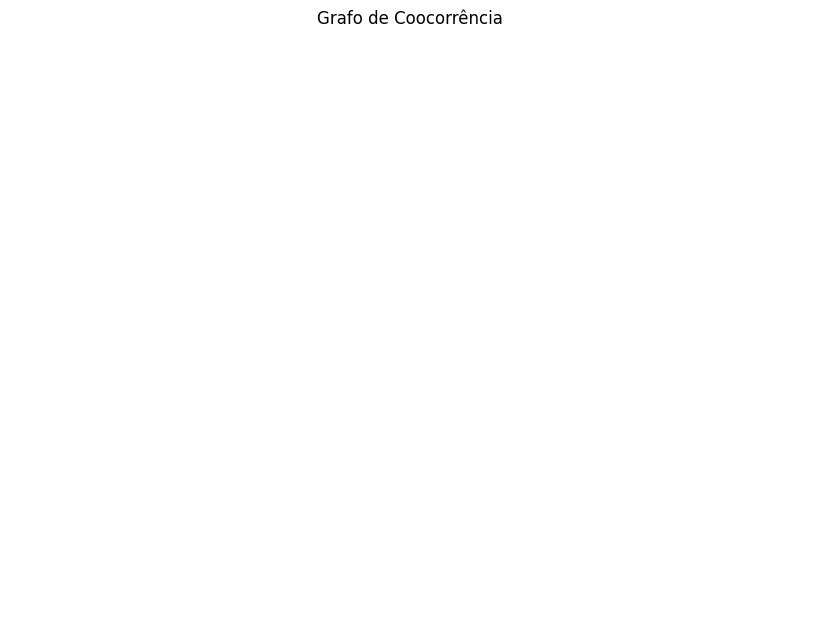

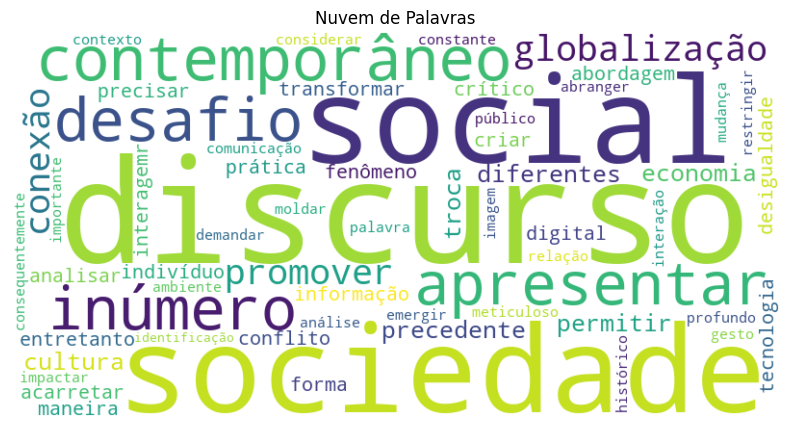

In [34]:
# 3. Captação de novo emergente
# 3.1 Análise de coocorrência
cooc_freq = Counter()
for sent in sentences:
    sent_tokens = [token.lemma_.lower() for token in sent if
                   token.is_alpha and token.text.lower() not in nlp.Defaults.stop_words]
    for a, b in combinations(set(sent_tokens), 2):
        a, b = sorted([a, b])
        cooc_freq[(a, b)] += 1

print("\nPares de palavras com coocorrência (frequência > 1):")
for pair, count in cooc_freq.items():
    if count > 1:
        print(f"  {pair}: {count}")

# 3.2 Visualização das relações entre categorias usando grafo de coocorrência
G = nx.Graph()
for (word1, word2), weight in cooc_freq.items():
    if weight > 1:
        G.add_edge(word1, word2, weight=weight)

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
plt.title("Grafo de Coocorrência")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras")
plt.show()

In [35]:
# 4. Metatexto
def summarize_text(doc, freq, ratio=0.4):
    sentence_scores = {}
    sentences = list(doc.sents)

    # Calcula a pontuação para cada sentença com base na frequência dos tokens
    for sent in sentences:
        for token in sent:
            key = token.lemma_.lower()
            if key in freq:
                sentence_scores[sent] = sentence_scores.get(sent, 0) + freq[key]

    num_sentences = max(1, int(len(sentences) * ratio))

    # Seleciona as sentenças com maior pontuação
    ranked_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)
    summary_sentences = sorted(ranked_sentences[:num_sentences], key=lambda s: s.start)

    # Concatena as sentenças selecionadas para formar o resumo
    summary = " ".join([sent.text for sent in summary_sentences])
    return summary


metatexto = summarize_text(doc, freq, ratio=0.4)
print("\nMetatexto gerado:")
print(metatexto)


Metatexto gerado:
A tecnologia digital transformou a maneira como indivíduos interagem, criando novas formas de comunicação e, consequentemente, impactando o discurso público. Além disso, é importante considerar que o discurso não se restringe a palavras, mas também abrange gestos, imagens e contextos históricos que moldam as relações de poder e identificação dentro da sociedade.



In [41]:
from openai import OpenAI

client = OpenAI(
    base_url="http://0.0.0.0:11434/v1",
    api_key="ollama"
)

messages = [
    {
        "role": "system",
        "content": (
            "Você é um analista discursivo experiente, capacitado para interpretar e analisar textos de maneira crítica e aprofundada, identificando relações de poder, significados emergentes e padrões discursivos."
        )
    },
    {
        "role": "user",
        "content": (
            f"A seguir, um resumo e alguns dados extraídos de uma análise textual discursiva:\n\n"
            f"Resumo: {metatexto}\n\n"
            f"Top 10 Palavras-Chave: {keywords}\n\n"
            "Com base nesses dados, por favor, elabore uma análise aprofundada dos temas emergentes, discutindo possíveis "
            "relações de poder e os significados presentes no discurso, identificando padrões e oferecendo interpretações críticas."
        )
    }
]

completion = client.chat.completions.create(
    model="deepseek-r1:7b", # ou qwen2.5:7b
    messages=messages,
    temperature=0,
    top_p=1,
)

print(completion.choices[0].message.content)

<think>
Okay, so I need to help this user who provided some data from a discourse analysis and wants an in-depth interpretation focusing on power relations and meanings. Let me start by understanding the context.

First, looking at the summary, it's about how digital technology changed communication and its impact on public discourse. The top keywords include 'discurso', 'sociedade', 'social', which suggests a focus on societal aspects within the discourse.

The user is an experienced discursive analyst, so they probably want a critical and deep analysis. They provided specific data points: 10 key words with their frequencies. I notice that 'discurso' appears three times, indicating it's central. 'sociedade' and 'social' are also prominent, which makes sense as the main themes.

I should start by unpacking each keyword. 'Discurso' is about discourse itself, so I'll need to explore how digital technology affects communication structures. The frequency of 3 suggests it's a major theme bu